# Smoothing Methods

* Simple / Single Exponential Smoothing (sadece durağan serileri, yani tred ve mevsimselliğin olamdığı serileri modelleyebilir.
)
* Double exponential smoothing (sadece trendin olduğu, mevsimselliğin olmadığı serileri modelleyebilir.)
* Triple exponential smoothin (hem trendi hem mevsimselliği modelleyebilir.) a.k.a. Holt-Winters

    Bizim için en iyi model en düşük hatayı veren modeldir.

## Simple / Single Exponential Smoothing

    Sadece durağan serilerde, yani trend ve mevsimselliğin olmadığı yöntemlerde kullanılır.


Aşağıda SES yönteminin formülünü görebilirsiniz.

<p align="center">
  <img src="grafikler/ts_4.png" height=75>
</p>

* Üssel düzeltme yaparak tahminde bulunur.
* Gelecek, yakın geçmişe daha fazla ilişkilendirilir varsayımıyla geçmişin etkileri ağırlıklandırılır.
* **Geçmiş gerçek değerler** ve **geçmiş tahmin edilen değerlerin** üssel olarak ağırlıklandırılmasıyla tahmin yapılır.

    Yukarıdaki alpha hiperparametresi "geçmiş gerçek değerlere" mi yoksa "geçmiş tahmin edilen değerlere" mi daha fazla ağırlık vereceğimizi ifade eder.
    
    Alphayı nasıl seçeceğiz bu hiper parametre görüldüğü üzere 1 ile 0 arasındadır ve optimize edilecektir.

Formüldeki **y<sub>t-1</sub>** kısmı learning, **ŷ<sub>t-1</sub>** kısmı ise remembering diye adlandırılır. Formülümüzde hem geçmiş dönemi hem de geçmişte tahmin edilen değerleri barındırıyoruz. Geçmişte tahmin edilen değerleri barındırma sebebimiz ise tahmin başarımızı da modelde buşundurma isteğimizden kaynaklanmaktadır.

Alpha ile alakalı;

<p align="center">
  <img src="grafikler/ts_5.png" height=400>
</p>

alpha ne kadar küçük ise modelimiz o kadar smooth olur !!!

### Uygulama Bölümü

In [2]:
# Kütüphanlerimizi import edelim;

import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings('ignore')

In [3]:
############################
# Veri Seti
############################

# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

# Aim: Forecasting air pollution in the next month

data = sm.datasets.co2.load_pandas()
data

<class 'statsmodels.datasets.utils.Dataset'>

In [4]:
# Yukarıda modelimiz bir nesne olarak geldi;
# Bir farklılık olarak aşağıdaki gibi bir bağımlı değişken ataması gerçekleştireceğiz;

y = data.data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


Yukarıda ilgili veri setinin haftalık olduğunu gözlemleyebiliyoruz. İlgil haftadaki CO2 miktarını göstermektedir.

In [5]:
# Biz bu haftalık veri setini aylık olarak düzenlemek istiyoruz;

# Zaman serilerinde bir veri setini aylık formata çevirmek için resample() formatını kullanıyoruz.
# daha fazla bilgi için dokümantasyona bakabilirsiniz;
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html#pandas.DataFrame.resample

# Aylık formata çevirdikten sonra ortalama alıyoruz;

y = y['co2'].resample('MS').mean()
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [6]:
# Yukarıda eksik değer olduğunu görüyoruz. 
# Zaman serilerinde eksik değerler, kendisinden önceki veya sonraki değerler ile doldurulabilir
# veya kendisinden önceki veya sonraki değerlerin ortalaması ile doldurulabilir.

# Şimdi veri setinde kaç adet eksik değer olduğuna bakalım;

y.isnull().sum()

# Veri setinde 5 adet eksik değer varmış.

5

In [7]:
# Burada eksik değerleri veri setindeki bir sonraki değer ile dolduracağız;

y = y.fillna(y.bfill())
y

# 6. aydaki eksik değerin gittiğini gözlemliyoruz.

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

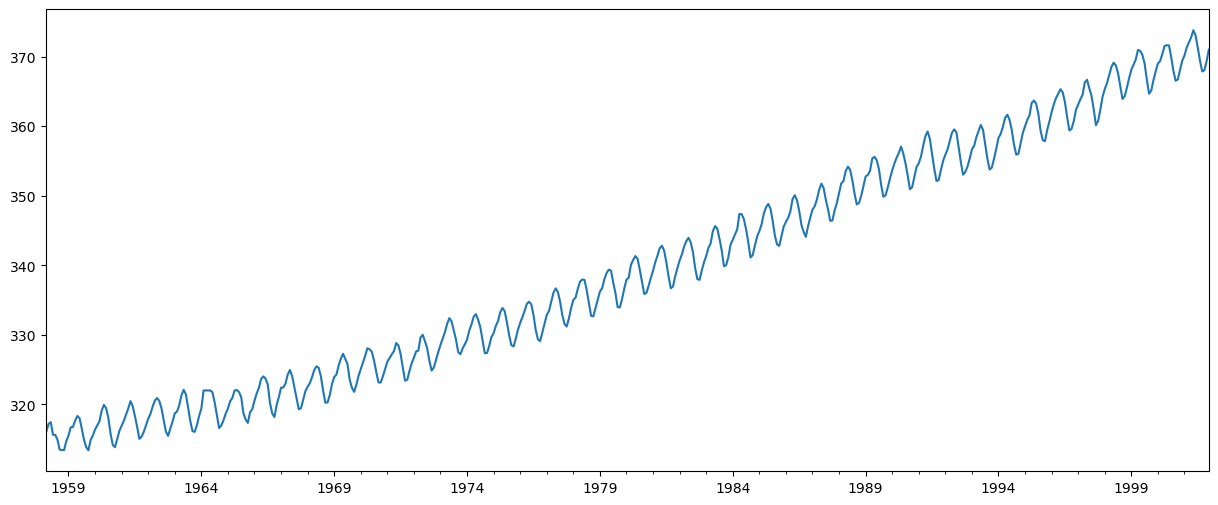

In [8]:
# Verimizi görselleştirelim;

y.plot(figsize=(15, 6))
plt.show()

Seri de hem trend, hem de mevsimsellik vardır. Trend olduğu için verimiz durağan değildir.

In [9]:
# Veri setimizi ikiye bölelim;
# Test ve Train olarak ayıralım;

train = y[:'1997-12-01']
print(len(train))  # 478 ay

# 1998'ilk ayından 2001'in sonuna kadar test set.
test = y['1998-01-01':]
print(len(test))  # 48 ay

478
48


    Zaman serisinde cross validation olmaz !!! Veri seti rasgele bölünürse trend ve mevsimsellik ortadan kalkar.

In [10]:
##################################################
# Zaman Serisi Yapısal Analizi
##################################################

In [11]:
# Durağanlık Testi (Dickey-Fuller Testi)

def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


    Aşağıda veri setinin bileşenlerini veriden ayıran bir fonksiyon tanımlayalım;

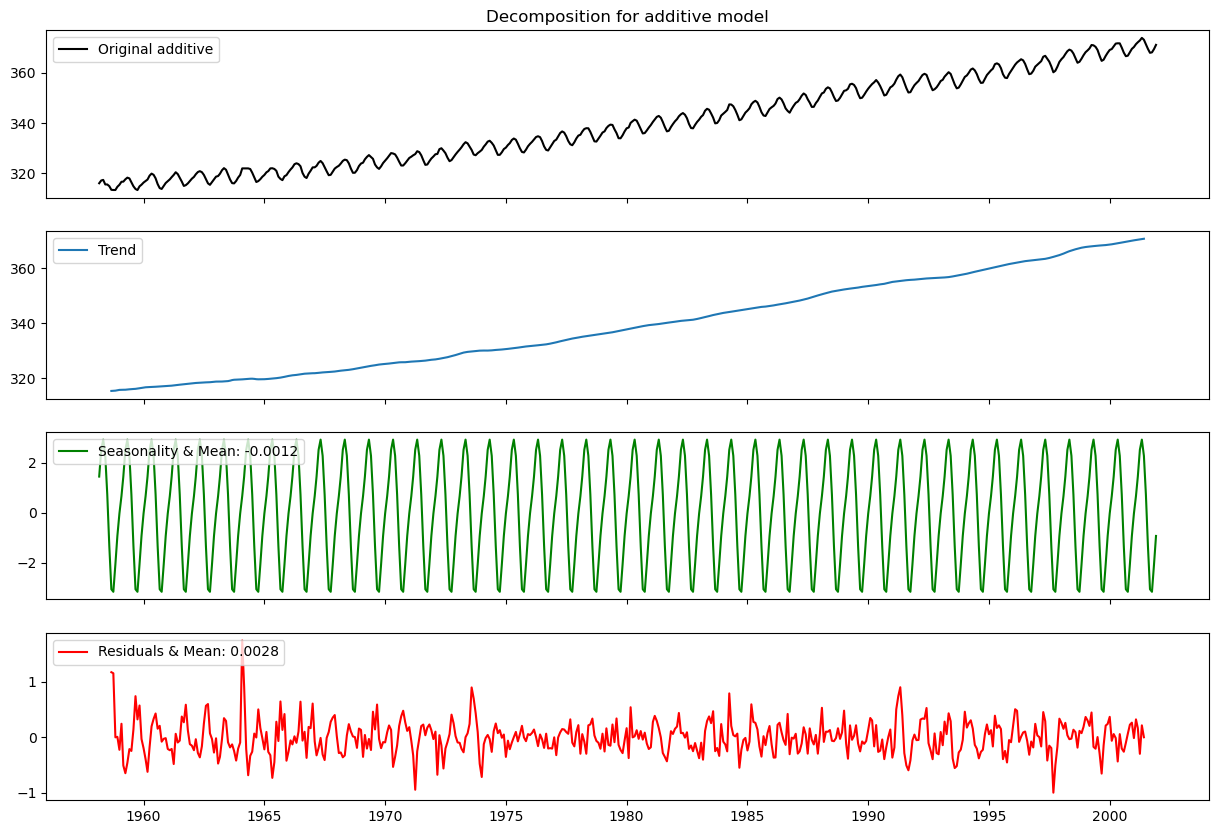

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [12]:
# Zaman Serisi Bileşenleri ve Durağanlık Testi
def ts_decompose(y, model="additive", stationary=False):

    # modelin çarpımsalm mı toplamsal mı olduğunu ifade ediyoruz.
    # İlerde çarpımsal ve toplamsal modellere değineceğiz.

    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    # Yukarıda "sharey=False" argümanı ile y eksenine bir kesme atıyoruz, 
    # True olarak değiştirip farkı gözlemleyebilrisiniz.
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

ts_decompose(y, stationary=True)

* İlk grafik verinin kendisidir,
* ikinci grafik verinin trend bilgisidir,
* üçüncü grafik verinin mevsimselliğidir,
* son grafik ise veriden trend ve mevsimsellik çıktıktan sonraki kalan durağan seridir.

In [13]:
##################################################
# Single Exponential Smoothing
##################################################

# SES Modelini kuracağımız bölüm

# SES = Level

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

# Model nesnemizi tanımlıyoruz, smoothing_level değerini de fit metodunun içerisine veriyoruz.
# "smoothing_level", alpha değeridir.

# "smoothing_level" girmeseydik de model optimize edip alpha'yi kendisi bulacaktı.

y_pred = ses_model.forecast(48)

# Zaman serilerinde özellikle holt-winters'da predict değil forecast kullanılır.
# 48 aya ilişkin tahminde bulunacağız.

mean_absolute_error(test, y_pred)
# 48 aylık tahmin ile test verimizi kıyasladık.

5.706393369643809

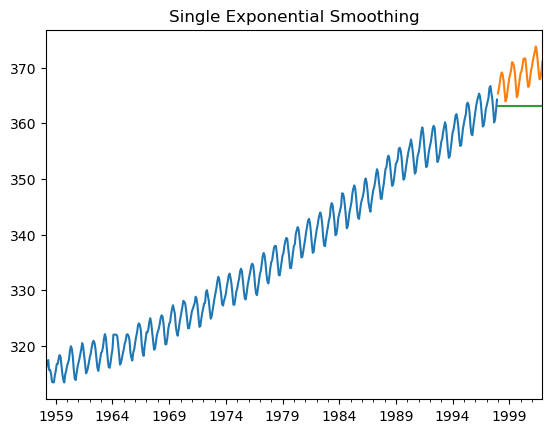

In [14]:
# Şimdi bir grafikle tahmin değerlerimize bakalım;

train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

Yukarıda yeşiller tahmin ettiğimiz değerler iken turuncular gerçek değerlerdir. 

Ne kadar da başarısız bir tahminde bulunulmuştur. :( 
    
Zaten **SES modelinin** trend ve mevsimsellik olan veride çok iyi bir tahminde bulunamayacağını başta söylemiştik.

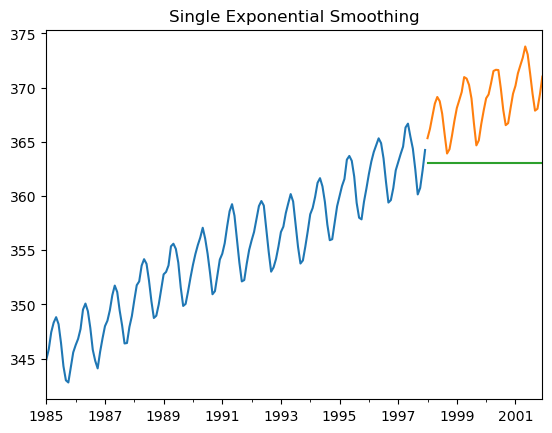

In [15]:
# Veri setine daha yakından bakmak istersek;

train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

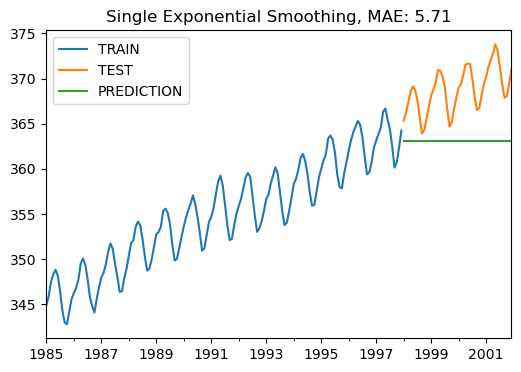

In [16]:
# Bu görselleri sık sık kullanacağımz için burada bir fonksiyon tanımlayalım;

def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")

    # Train 1985 başka veri setini görselleştirirken işe yaramaz bir hale gelebilir.
    # Bunu değerlendirmeye alalım.

    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [17]:
# Modelin hiper parametrelerini çağıralım;

ses_model.params

# Aşağıda bir kaç hiper parametre bizim dikkatimizi çekiyor;

# 'smoothing_trend': nan
# 'smoothing_seasonal': nan

# Yukarıdaki hiper parametrelere baktığımızda görüyoruz ki;
# "SimpleExpSmoothing()" nesnesi üzerinden hem "DES" hem de "TES" algoritmalarını/yöntemlerini de kuruyormuşuz.

# Yukarıda eğer ki "smoothing_level"ı argüman olarak göndermezsek,
# modelin bu hiper parametreyi optimize edeceğini söylemiştik.

# "smoothing_level"ı argüman olarak göndermediğimizde modelin yöntem olarak SES'i otomatik seçtiğini algılayabiliriz.

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.4419309772571,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [18]:
############################
# Hyperparameter Optimization
############################

In [19]:
# Modelimizde en iyi alphayı arayacak bir fonksiyon tanımlayalım;

def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return round(best_alpha, 2), round(best_mae, 4)

In [20]:
# Denenecek alpha'ları tanımlayalım;

alphas = np.arange(0, 1.01, 0.01)
alphas

# 0.01 makine öğrenmesindeki learning_rate gibidir.

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [21]:
# Modelimizin best alpha'sına bakalım;

best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.0 mae: 32.0647
alpha: 0.01 mae: 16.1726
alpha: 0.02 mae: 10.4344
alpha: 0.03 mae: 8.4534
alpha: 0.04 mae: 7.481
alpha: 0.05 mae: 6.9109
alpha: 0.06 mae: 6.544
alpha: 0.07 mae: 6.2957
alpha: 0.08 mae: 6.1232
alpha: 0.09 mae: 6.0017
alpha: 0.1 mae: 5.9159
alpha: 0.11 mae: 5.8559
alpha: 0.12 mae: 5.8146
alpha: 0.13 mae: 5.7872
alpha: 0.14 mae: 5.7702
alpha: 0.15 mae: 5.7612
alpha: 0.16 mae: 5.758
alpha: 0.17 mae: 5.7593
alpha: 0.18 mae: 5.7639
alpha: 0.19 mae: 5.7709
alpha: 0.2 mae: 5.7795
alpha: 0.21 mae: 5.7893
alpha: 0.22 mae: 5.7998
alpha: 0.23 mae: 5.8104
alpha: 0.24 mae: 5.821
alpha: 0.25 mae: 5.8312
alpha: 0.26 mae: 5.8409
alpha: 0.27 mae: 5.8497
alpha: 0.28 mae: 5.8577
alpha: 0.29 mae: 5.8645
alpha: 0.3 mae: 5.8703
alpha: 0.31 mae: 5.8747
alpha: 0.32 mae: 5.8779
alpha: 0.33 mae: 5.8797
alpha: 0.34 mae: 5.8801
alpha: 0.35 mae: 5.8791
alpha: 0.36 mae: 5.8767
alpha: 0.37 mae: 5.8728
alpha: 0.38 mae: 5.8675
alpha: 0.39 mae: 5.8609
alpha: 0.4 mae: 5.8528
alpha: 0.41 mae: 5.843

    En iyi alphayı 1 olarak buldu.

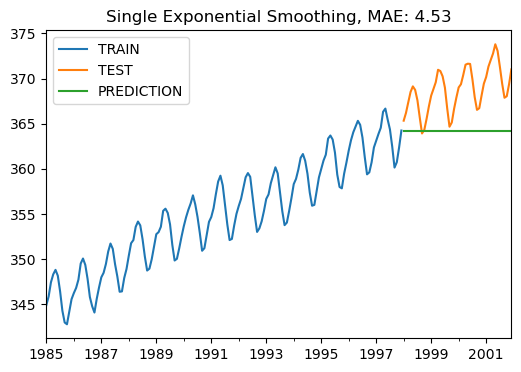

In [22]:
# Final modelimize bakalım;

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

    SES modelinin trendi ve mevsimselliği modelleyemediğinin en büyük kanıtını yukarıdaki grafikten görebiliriz.

In [23]:
##################################################
# Double Exponential Smoothing (DES)
##################################################

# DES: Level (SES) + Trend

# DES'i tek değişkenli, trendli verilerde kullanırız.

<p align="center">
  <img src="grafikler/ts_6.png" height=400>
</p>

In [24]:
# Daha önceden toplamsal model ve çarpımsal modeller olduğundan bahsetmiştik;
# İkisinin arasındaki farka aşağıdan ulaşabilirsiniz;

# Additive model;
# y(t) = Level + Trend + Seasonality + Noise

# Multiplicative model;
# y(t) = Level * Trend * Seasonality * Noise

# NOT !!! : Mevsimsellik ve artık bileşenler trendden bağımsız ise seri toplamsaldır.
#           Mevsimsellik ve artık bileşenler trende  bağımlı ise seri çarpımsaldır.

    Additive seri ile multiplicative seri arasındaki farka görsel olarak bakalım;    

<p align="center">
  <img src="grafikler/ts_7.png">
</p>

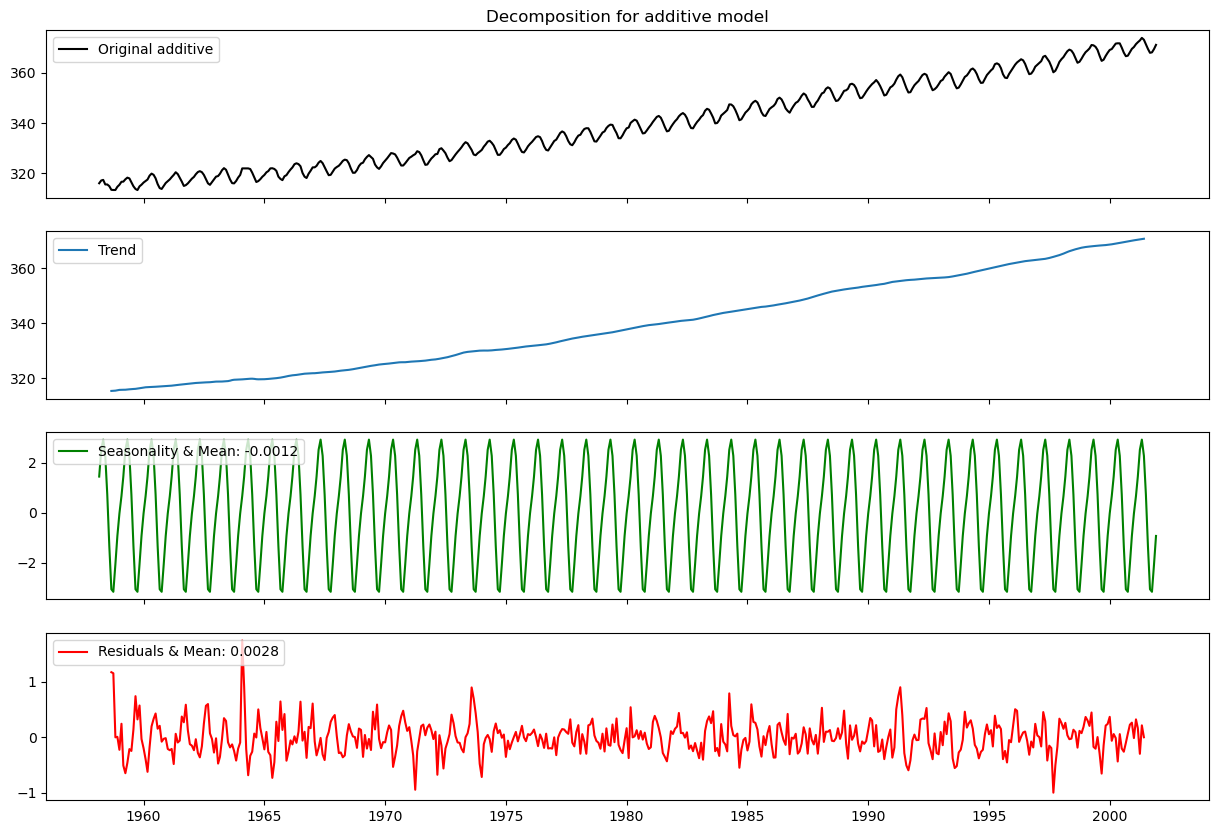

In [25]:
# Verimizi bir de compose edelim;

ts_decompose(y)

    Trendimizin additive olduğunu görüyoruz.

Artıklar da durağandır. Eğer ki artıklarımız devamlı olarak artsaydı, modelimiz multiplicative olurdu.

Lakin bizler additive modelin mi yoksa multiplicative modelin mi daha iyi olduğuna, modeli iki şekilde de kurup en düşük hata hangisinde ise o modelin daha iyi olduğunu söyleyerek karar vermeliyiz.

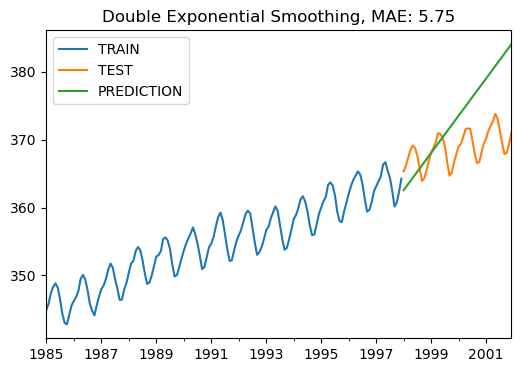

In [26]:
# Modelimizi kuralım;

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

# Tahminimizi yapalım;
y_pred = des_model.forecast(48)

# Grafiğine bakalım;
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

In [27]:
############################
# Hyperparameter Optimization
############################

In [28]:
# Modelimizde en iyi alpha ve betayı arayacak bir fonksiyon tanımlayalım;

def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


In [29]:
# Hiper parametrelerimizi belirleyelim;

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7412
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8522
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

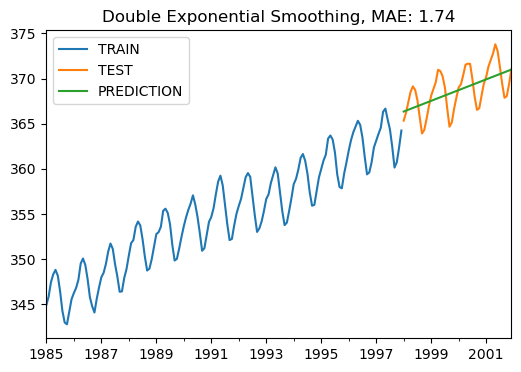

In [30]:
# Final modelimize bakalım;

# Final modelimizi kuralım;
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

# Eğer ki multiplicative bir model kurmak istersek;
# Model nesnesi içerisinde bulunan "trend=" argümanını "mul" yapmak gerekir.

# Final modele göre forecast edelim;
y_pred = final_des_model.forecast(48)

# Grafikleri çizdirelim;

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

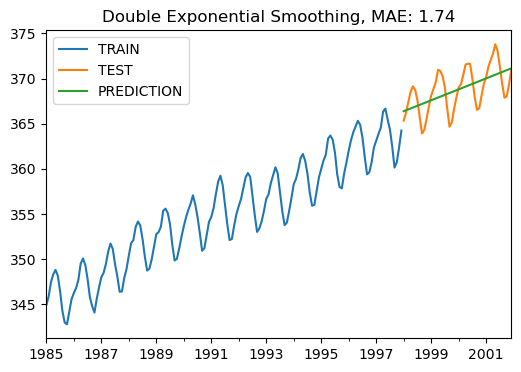

In [31]:
# Final modelimize bakalım;

# Final modelimizi kuralım;
final_des_model = ExponentialSmoothing(train, trend="mul").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

# Eğer ki multiplicative bir model kurmak istersek;
# Model nesnesi içerisinde bulunan "trend=" argümanını "mul" yapmak gerekir.

# Final modele göre forecast edelim;
y_pred = final_des_model.forecast(48)

# Grafikleri çizdirelim;

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

In [32]:
##################################################
# Triple Exponential Smoothing (Holt-Winters)
##################################################

# TES = SES + DES + Mevsimsellik

# TES'i tek değişkenli, trendli ve mevsimsellik içeren verilerde kullanırız.

<p align="center">
  <img src="grafikler/ts_8.png" height =400>
</p>

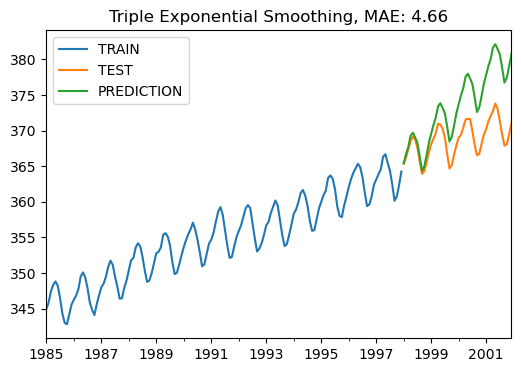

In [33]:
# Modelimizi kuralım;

tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

# Yukarıda "seasonal_periods=" argümanı ile mevsimsellik katsayısını belirtiyoruz.

# Önümüzdeki 48 dönemi forecast edelim;
y_pred = tes_model.forecast(48)

# Grafiğini çizdirelim;
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [34]:
############################
# Hyperparameter Optimization
############################

In [35]:
alphas = betas = gammas = np.arange(0.20, 1, 0.10)

In [36]:
abg = list(itertools.product(alphas, betas, gammas))
abg[0:5]

# Yukarıda itertool.product ile, hiperparametrelerin olası kombinasyonlarını getirmiş olduk.
# Zira aşağıda fonksiyon tanımlarken üç adet iç içe döngü yazmak istemedik.

[(0.2, 0.2, 0.2),
 (0.2, 0.2, 0.30000000000000004),
 (0.2, 0.2, 0.4000000000000001),
 (0.2, 0.2, 0.5000000000000001),
 (0.2, 0.2, 0.6000000000000001)]

In [37]:
# En iyi alpha, beta ve gamma parametresini arayacak bir fonksiyon tanımlayalım;

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


# Best hiper parametreleri arayalım;
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)


[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.73]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.39]
[0.2, 0.4, 0.8, 11.66]
[0.2, 0.4, 0.9, 4.52]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.84]
[0.2, 0.5, 0.7, 3.35]
[0.2, 0.5, 0.8, 4.63]
[0.2, 0.5, 0.9, 3.43]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.72]
[0.2, 0.6, 0.5, 1.08]
[0.2, 0.6, 0.6, 1.64]
[0.2, 0.6, 0.7, 2.68]
[0.2, 0.6, 0.8, 5752.04]
[0.2, 0.6, 0.9, 4631420571511563.0]
[0.2, 0.7, 0.2, 4.72]
[0.2, 0.7, 0.3, 4.56]
[0.2, 0.7, 0.4, 6.58]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6,

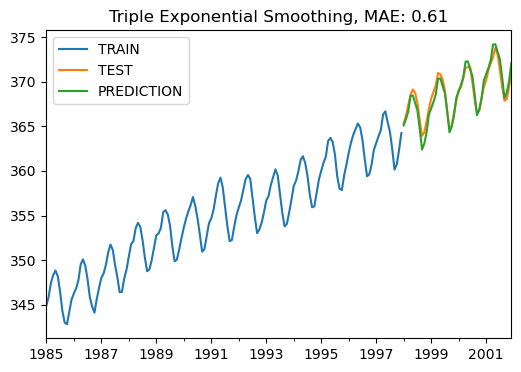

In [38]:
# Final modelimizi kuralım;

final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

# Final modeli ile forecast edelim;
y_pred = final_tes_model.forecast(48)

# Grafiğimizi yazdıralım;
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")